In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
def polynomial_dataframe(feature, degree):
    poly_data = pd.DataFrame()
    poly_data['power_1'] = feature
    if degree <= 1: return poly_data
    for i in range(2,degree+1):
        column = 'power_' + str(i)
        prev = 'power_' + str(i-1)
        poly_data[column] = poly_data[prev] * feature
    return poly_data

# load data and sort

In [3]:
sales = pd.read_csv('kc_house_data.csv')
sales = sales.sort_values(['sqft_living','price'])

# 15th degree polynomial l2-penalty fit

In [6]:
poly15_data = polynomial_dataframe(sales['sqft_living'], 15)
model = linear_model.Ridge(alpha= 1.5e-5, normalize=True)
model.fit(poly15_data, sales['price'])

Ridge(alpha=1.5e-05, normalize=True)

In [8]:
print(model.coef_[0])

70.10201315760021


# observe overfitting, variance is large


62.38577180045441

-219.8946861793213

-198.97017666641258

-34.82482021602332


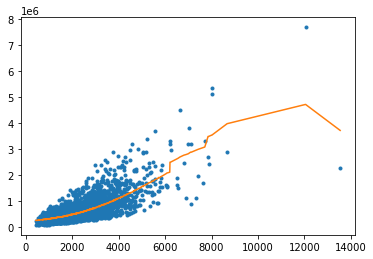

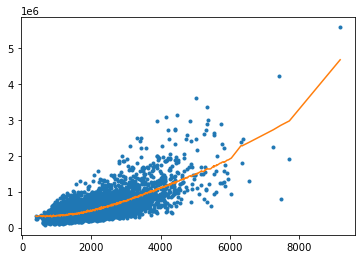

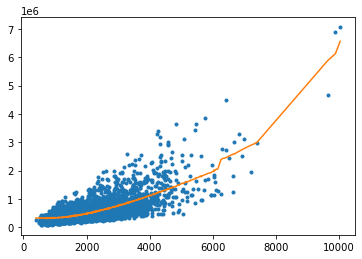

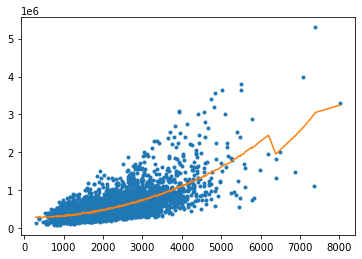

In [13]:
for i in range(1,5):
    set_i = pd.read_csv('wk3_kc_house_set_' + str(i) + '_data.csv')
    set_i = set_i.sort_values(['sqft_living','price'])
    poly15_data_i = polynomial_dataframe(set_i['sqft_living'], 15)
    l2_penalty = 1e-9
    model_i = linear_model.Ridge(alpha=l2_penalty, normalize=True)
    model_i.fit(poly15_data_i, set_i['price'])
    print()
    plt.figure(i)
    plt.plot(poly15_data_i['power_1'],set_i['price'],'.')
    plt.plot(poly15_data_i['power_1'],model_i.predict(poly15_data_i))
    print(model_i.coef_[0])

# ridge regression


2.333022928259653

2.107722686907466

2.311236407795472

2.1001837846924767


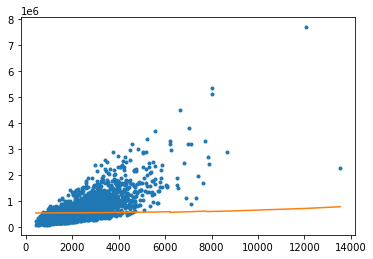

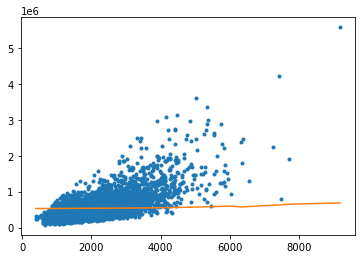

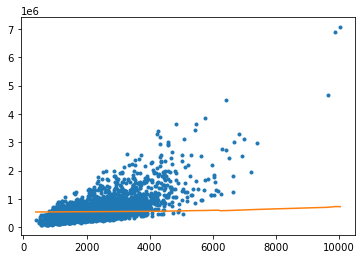

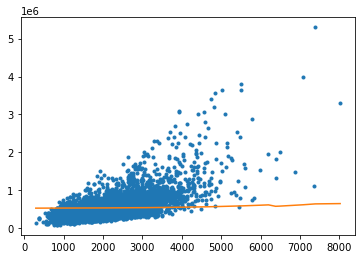

In [14]:
for i in range(1,5):
    set_i = pd.read_csv('wk3_kc_house_set_' + str(i) + '_data.csv')
    set_i = set_i.sort_values(['sqft_living','price'])
    poly15_data_i = polynomial_dataframe(set_i['sqft_living'], 15)
    l2_penalty = 1.23e2
    model_i = linear_model.Ridge(alpha=l2_penalty, normalize=True)
    model_i.fit(poly15_data_i, set_i['price'])
    print()
    plt.figure(i)
    plt.plot(poly15_data_i['power_1'],set_i['price'],'.')
    plt.plot(poly15_data_i['power_1'],model_i.predict(poly15_data_i))
    print(model_i.coef_[0])

# cross-validation to select the l2 penalty parameter

In [24]:
train_valid_data = pd.read_csv('wk3_kc_house_train_valid_shuffled.csv')
train_valid_data = train_valid_data.sort_values(['sqft_living','price'])
train_valid_feature = polynomial_dataframe(train_valid_data['sqft_living'],15)
test_data = pd.read_csv('wk3_kc_house_test_data.csv')
test_data = test_data.sort_values(['sqft_living','price'])
test_data = polynomial_dataframe(test_data['sqft_living'],15)

In [65]:
def k_fold_corss_validation(k, l2_penalty, data, output):
    n = len(data)
    k = 10
    err = []
    for i in range(k):
        start = (n*i) // k
        end = (n*(i+1)) // k
        valid_subset = data[start:end]
        train_subset = data[0:start].append(data[end:])
        train_output_subset = output[0:start].append(output[end:])
        valid_output_subset = output[start:end]
        model = linear_model.Ridge(alpha= l2_penalty, normalize= True)
        model.fit(train_subset, train_output_subset)
        pred = model.predict(valid_subset)
        err.append(np.linalg.norm(pred - valid_output_subset.to_numpy()) ** 2)
    valid_err = sum(err)/len(err)
    return valid_err

In [66]:
lams = np.exp(np.log(10)*np.linspace(3,9,num=13))
errs = []
for lam in lams:
    res = k_fold_corss_validation(k=10, l2_penalty=lam, data=train_valid_feature, output=train_valid_data['price'])
    errs.append(res)

In [68]:
print(errs)
print(min(errs))

[288884432672969.5, 290687827904096.7, 291263873911020.7, 291446616162468.0, 291504462523380.1, 291522760971871.94, 291528548031797.3, 291530378119077.4, 291530956849314.5, 291531139860466.94, 291531197733733.1, 291531216034872.6, 291531221822201.7]
288884432672969.5


# use best performed l2-penalty, train and test

In [71]:
final_train = pd.read_csv('wk3_kc_house_train_data.csv')
final_input_feature = polynomial_dataframe(final_train['sqft_living'],15)
final_test = pd.read_csv('wk3_kc_house_test_data.csv')
final_test_input_feature = polynomial_dataframe(final_test['sqft_living'],15)
model_best = linear_model.Ridge(alpha= lams[0], normalize=True)
model_best.fit(final_input_feature, final_train['price'])
pred = model_best.predict(final_test_input_feature)
print('%.2e'%np.linalg.norm(pred - final_test['price'].to_numpy())**2)
print(model_best.coef_)

2.84e+14
[ 2.87617885e-01  5.23074878e-05  7.58533010e-09  7.15618558e-13
  2.24793755e-16 -3.19661845e-18  1.81837458e-18 -1.65305177e-18
 -1.76446462e-18 -1.03492802e-18  9.36939005e-19 -8.37503529e-19
  2.17519472e-19 -1.85701951e-18 -3.22159862e-18]
